# Compas Data Imputation Analysis

In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from utils.data import create_compas_dataset, Dataset
from utils.generator import gen_complete_random
from utils.completer import complete_by_mean_col, complete_by_multi, complete_by_similar_row

In [4]:
data = create_compas_dataset()

In [5]:
data_compas_complete = data.copy()
tmp_concat = pd.concat([data_compas_complete.X, pd.DataFrame(data_compas_complete.y, columns=["_TARGET_"])], axis=1)
tmp_concat.dropna(inplace=True)
tmp_concat.reset_index(drop=True, inplace=True)
data_compas_complete.X = tmp_concat.drop(columns=["_TARGET_"]).copy()
data_compas_complete.y = tmp_concat["_TARGET_"].copy().to_numpy().ravel()

In [6]:
X = data_compas_complete.X.drop(columns=data_compas_complete.protected).copy().to_numpy()
y = data_compas_complete.y.copy()

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

In [8]:
from imblearn.over_sampling import SVMSMOTE

### Parameter Searching

In [9]:
from sklearn.model_selection import GridSearchCV

def grid_search(X, y, model, params, smote):
    print("Model: {}".format(model.__class__.__name__))
    X_res, y_res = smote.fit_resample(X, y) # enlarge dataset
    search = GridSearchCV(model, param_grid=params, cv=10, n_jobs=-1)
    search.fit(X_res, y_res)
    print("Best parameter: {}".format(search.best_params_))
    print("Acc best: {:.4f}".format(search.best_score_))
    print("Acc on input data: {:.4f}".format(search.best_estimator_.score(X, y)))
    print("Acc on enlarged data: {:.4f}".format(search.best_estimator_.score(X_res, y_res)))
    return search.best_params_

In [10]:
all_params = {
    "KNN": None,
    "LinearSVC": None,
    "SVC": None,
    "Forest": None,
    "LogReg": None,
    "Tree": None,
    "MLP": None,
}

In [11]:
tmp_params = {
    "n_neighbors": [2, 5, 10, 50, 100, 500],
    "leaf_size": [5, 10, 30, 50, 100],
}
all_params["KNN"] = grid_search(X, y, KNeighborsClassifier(), tmp_params, SVMSMOTE(random_state=22))

Model: KNeighborsClassifier
Best parameter: {'leaf_size': 5, 'n_neighbors': 2}
Acc best: 0.7061
Acc on input data: 0.8993
Acc on enlarged data: 0.9071


In [12]:
tmp_params = {
    "tol": [1e-5, 1e-4, 1e-3],
    "C": [0.001, 0.01, 0.1, 1, 10],
    "max_iter": [1000, 5000, 10000],
}
all_params["LinearSVC"] = grid_search(X, y, LinearSVC(dual=False), tmp_params, SVMSMOTE(random_state=22))

Model: LinearSVC
Best parameter: {'C': 0.1, 'max_iter': 1000, 'tol': 0.001}
Acc best: 0.6728
Acc on input data: 0.6641
Acc on enlarged data: 0.6725


In [13]:
tmp_params = {
    "tol": [1e-5, 1e-4, 1e-3],
    "C": [0.001, 0.01, 0.1, 1, 10],
    "max_iter": [1000, 5000, 10000, -1],
}
all_params["SVC"] = grid_search(X, y, SVC(), tmp_params, SVMSMOTE(random_state=22))

Model: SVC
Best parameter: {'C': 10, 'max_iter': -1, 'tol': 0.0001}
Acc best: 0.6452
Acc on input data: 0.6285
Acc on enlarged data: 0.6489


In [14]:
tmp_params = {
    "n_estimators": [50, 100, 200, 500],
    "max_depth": [None, 10, 50, 100],
    "min_samples_leaf": [1, 5, 10],
}
all_params["Forest"] = grid_search(X, y, RandomForestClassifier(), tmp_params, SVMSMOTE(random_state=22))

Model: RandomForestClassifier
Best parameter: {'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 100}
Acc best: 0.7677
Acc on input data: 0.8166
Acc on enlarged data: 0.8567


In [15]:
tmp_params = {
    "tol": [1e-5, 1e-4, 1e-3],
    "C": [1e-2, 1e-1, 1, 1e1, 1e2],
    "max_iter": [100, 500, 1000, 2000],
}
all_params["LogReg"] = grid_search(X, y, LogisticRegression(), tmp_params, SVMSMOTE(random_state=22))

Model: LogisticRegression
Best parameter: {'C': 10.0, 'max_iter': 100, 'tol': 1e-05}
Acc best: 0.6755
Acc on input data: 0.6767
Acc on enlarged data: 0.6762


In [16]:
tmp_params = {
    "max_depth": [None, 10, 50, 100, 200],
    "max_leaf_nodes": [None, 10, 100, 1000],
    "min_samples_leaf": [1, 5, 10],
}
all_params["Tree"] = grid_search(X, y, DecisionTreeClassifier(), tmp_params, SVMSMOTE(random_state=22))

Model: DecisionTreeClassifier
Best parameter: {'max_depth': 10, 'max_leaf_nodes': 100, 'min_samples_leaf': 1}
Acc best: 0.7494
Acc on input data: 0.7267
Acc on enlarged data: 0.7765


In [17]:
tmp_params = {
    "alpha": [1e-5, 1e-4, 1e-3],
    "learning_rate_init": [1e-4, 1e-3, 1e-2],
    "max_iter": [200, 500, 1000],
}
all_params["MLP"] = grid_search(X, y, MLPClassifier(), tmp_params, SVMSMOTE(random_state=22))

Model: MLPClassifier
Best parameter: {'alpha': 0.0001, 'learning_rate_init': 0.01, 'max_iter': 500}
Acc best: 0.6878
Acc on input data: 0.6685
Acc on enlarged data: 0.6911


### Data Imputation

In [193]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

def bias1(data):
    # input should be data from compute_confusion_matrix: [tn, fp, fn, tp]
    # bias 1 = |(FPR_AA/FNR_AA) - (FPR_C/FNR_C)|
    FPR_AA = data["African-American"][1] / (data["African-American"][1] + data["African-American"][0])
    FNR_AA = data["African-American"][2] / (data["African-American"][2] + data["African-American"][3])
    FPR_C = data["Caucasian"][1] / (data["Caucasian"][1] + data["Caucasian"][0])
    FNR_C = data["Caucasian"][2] / (data["Caucasian"][2] + data["Caucasian"][3])
    bias = (FPR_AA / FNR_AA) - (FPR_C / FNR_C)
    return abs(bias)
   
def bias2(data):
    # input should be data from compute_confusion_matrix
    # bias 2 = |(FPR_AA/FPR_C) - (FNR_AA/FNR_C)|
    FPR_AA = data["African-American"][1] / (data["African-American"][1] + data["African-American"][0])
    FNR_AA = data["African-American"][2] / (data["African-American"][2] + data["African-American"][3])
    FPR_C = data["Caucasian"][1] / (data["Caucasian"][1] + data["Caucasian"][0])
    FNR_C = data["Caucasian"][2] / (data["Caucasian"][2] + data["Caucasian"][3])
    bias = (FPR_AA / FPR_C) - (FNR_AA / FNR_C)
    return abs(bias)

def helper_freq(array):
    """simple helper function to return the most frequent number in an array"""
    count = np.bincount(array)
    return array[np.argmax(count)]

def average_cv(cv_data):
    # compute average for the confusion matrix data for each fold
    result = {}
    for name, data in cv_data.items():
        new_data = {
            "African-American": np.array([m["African-American"] for m in data]).mean(axis=0).tolist(),
            "Caucasian": np.array([m["Caucasian"] for m in data]).mean(axis=0).tolist()
        }
        result[name] = new_data
    return result

def compute_confusion_matrix(X_train, y_train, X_test, y_test, clf, protected_features, multi=False):
    # X are pandas dataframe
    # y are numpy array
    # clf is a sklearn classifier
    # protected_features is list
    smote = SVMSMOTE(random_state=22)
    if not multi:
        X_train = X_train.drop(columns=protected_features).copy().to_numpy()
        X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
        clf.fit(X_train_res, y_train_res)
        print("Acc: {:.4f}".format(clf.score(X_test.drop(columns=protected_features).copy().to_numpy(), y_test)), end=" ")
        X_test_AA = X_test[X_test["race"] == "African-American"].drop(columns=protected_features).to_numpy()
        X_test_C = X_test[X_test["race"] == "Caucasian"].drop(columns=protected_features).to_numpy()
        y_test_AA = y_test[X_test[X_test["race"] == "African-American"].index.tolist()]
        y_test_C = y_test[X_test[X_test["race"] == "Caucasian"].index.tolist()]
        matrix_AA = confusion_matrix(y_test_AA, clf.predict(X_test_AA))
        matrix_C = confusion_matrix(y_test_C, clf.predict(X_test_C))
    else:
        prediction_AA = []
        prediction_C = []
        X_test_first = X_test[0]
        y_test_AA = y_test[X_test_first[X_test_first["race"] == "African-American"].index.tolist()]
        y_test_C = y_test[X_test_first[X_test_first["race"] == "Caucasian"].index.tolist()]
        scores = [0, 0]
        for X_train_m in X_train:
            X_train_m = X_train_m.drop(columns=protected_features).copy().to_numpy()
            X_train_res, y_train_res = smote.fit_resample(X_train_m, y_train)
            clf.fit(X_train_res, y_train_res)
            for X_test_m in X_test:
                X_test_AA = X_test_m[X_test_m["race"] == "African-American"].drop(columns=protected_features).to_numpy()
                X_test_C = X_test_m[X_test_m["race"] == "Caucasian"].drop(columns=protected_features).to_numpy()
                prediction_AA.append(clf.predict(X_test_AA))
                prediction_C.append(clf.predict(X_test_C))
                scores[0] += clf.score(X_test_m.drop(columns=protected_features).copy().to_numpy(), y_test)
                scores[1] += 1
        print("Acc: {:.4f}".format(scores[0] / scores[1]), end=" ")
        # compute final predictions by voting
        prediction_AA = np.apply_along_axis(helper_freq, 0, np.array(prediction_AA))
        prediction_C = np.apply_along_axis(helper_freq, 0, np.array(prediction_C))
        matrix_AA = confusion_matrix(y_test_AA, prediction_AA)
        matrix_C = confusion_matrix(y_test_C, prediction_C)
    result = {
        "African-American": matrix_AA.ravel().tolist(), # [tn, fp, fn, tp]
        "Caucasian": matrix_C.ravel().tolist()
    }
    return result

def test_imputation(X, y, protected_features, completer_func=None, multi=False):
    # X is pandas dataframe
    # y is numpy array,
    # protected_features is list
    # completer func is the imputation function
    global all_params
    clfs = { # define all the classifiers with best parameters
        "KNN": KNeighborsClassifier(n_neighbors=all_params["KNN"]["n_neighbors"], leaf_size=all_params["KNN"]["leaf_size"]),
        "LinearSVC": LinearSVC(dual=False, tol=all_params["LinearSVC"]["tol"], C=all_params["LinearSVC"]["C"], max_iter=all_params["LinearSVC"]["max_iter"]),
        "SVC": SVC(tol=all_params["SVC"]["tol"], C=all_params["SVC"]["C"], max_iter=all_params["SVC"]["max_iter"]),
        "Forest": RandomForestClassifier(n_estimators=all_params["Forest"]["n_estimators"], max_depth=all_params["Forest"]["max_depth"], min_samples_leaf=all_params["Forest"]["min_samples_leaf"]),
        "LogReg": LogisticRegression(tol=all_params["LogReg"]["tol"], C=all_params["LogReg"]["C"], max_iter=all_params["LogReg"]["max_iter"]),
        "Tree": DecisionTreeClassifier(max_depth=all_params["Tree"]["max_depth"], max_leaf_nodes=all_params["Tree"]["max_leaf_nodes"], min_samples_leaf=all_params["Tree"]["min_samples_leaf"]),
        "MLP": MLPClassifier(alpha=all_params["MLP"]["alpha"], learning_rate_init=all_params["MLP"]["learning_rate_init"], max_iter=all_params["MLP"]["max_iter"]),
    }
    data_cv = { # save each cv output
        "KNN": [],
        "LinearSVC": [],
        "SVC": [],
        "Forest": [],
        "LogReg": [],
        "Tree": [],
        "MLP": [],
    }
    bias1_cv = { # save each bias 1 outputs
        "KNN": [],
        "LinearSVC": [],
        "SVC": [],
        "Forest": [],
        "LogReg": [],
        "Tree": [],
        "MLP": [],
    }
    bias2_cv = { # save each bias 2 outputs
        "KNN": [],
        "LinearSVC": [],
        "SVC": [],
        "Forest": [],
        "LogReg": [],
        "Tree": [],
        "MLP": [],
    }
    kf = KFold(n_splits=10, shuffle=True)
    fold = 1
    for train_idx, test_idx in kf.split(X):
        print("Fold {:>2}".format(fold), end=" ")
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        X_test = X_test.reset_index(drop=True)
        X_train = X_train.reset_index(drop=True)
        if completer_func:
        # do imputations on training set and test set individually
            data_incomplete = Dataset("tmp", X_train, y_train, auto_convert=False, protected_features=protected_features)
            data_complete = completer_func(data_incomplete)
            X_train = [m.X.copy() for m in data_complete] if multi else data_complete.X.copy() 
            y_train = data_complete[0].y.copy() if multi else data_complete.y.copy()
            data_incomplete = Dataset("tmp", X_test, y_test, auto_convert=False, protected_features=protected_features)
            data_complete = completer_func(data_incomplete)
            X_test = [m.X.copy() for m in data_complete] if multi else data_complete.X.copy()
            y_test = data_complete[0].y.copy() if multi else data_complete.y.copy()
        # get result for each classifier
        for clf_name, clf in clfs.items():
            print("{}".format(clf_name), end=" ")
            result = compute_confusion_matrix(X_train, y_train, X_test, y_test, clf, protected_features, multi=multi)
            data_cv[clf_name].append(result)
            bias1_cv[clf_name].append(bias1(result))
            bias2_cv[clf_name].append(bias2(result))
        print()
        fold += 1
    # print("Result:\n{}".format(data_cv))
    return (data_cv, bias1_cv, bias2_cv)

In [219]:
# try on original data
result_original = test_imputation(data_compas_complete.X.copy(), data_compas_complete.y.copy(), data_compas_complete.protected)

Fold  1 KNN Acc: 0.6368 LinearSVC Acc: 0.6890 SVC Acc: 0.6496 Forest Acc: 0.7220 LogReg Acc: 0.6944 Tree Acc: 0.6901 MLP Acc: 0.6656 
Fold  2 KNN Acc: 0.6432 LinearSVC Acc: 0.6475 SVC Acc: 0.5868 Forest Acc: 0.6869 LogReg Acc: 0.6571 Tree Acc: 0.6741 MLP Acc: 0.6550 
Fold  3 KNN Acc: 0.6347 LinearSVC Acc: 0.6890 SVC Acc: 0.6358 Forest Acc: 0.7039 LogReg Acc: 0.6912 Tree Acc: 0.6784 MLP Acc: 0.6890 
Fold  4 KNN Acc: 0.6230 LinearSVC Acc: 0.6752 SVC Acc: 0.6145 Forest Acc: 0.6944 LogReg Acc: 0.6858 Tree Acc: 0.6826 MLP Acc: 0.6422 
Fold  5 KNN Acc: 0.6493 LinearSVC Acc: 0.6716 SVC Acc: 0.6322 Forest Acc: 0.7292 LogReg Acc: 0.6887 Tree Acc: 0.6919 MLP Acc: 0.6578 
Fold  6 KNN Acc: 0.6407 LinearSVC Acc: 0.6663 SVC Acc: 0.5938 Forest Acc: 0.6844 LogReg Acc: 0.6652 Tree Acc: 0.6962 MLP Acc: 0.6141 
Fold  7 KNN Acc: 0.6407 LinearSVC Acc: 0.6738 SVC Acc: 0.5928 Forest Acc: 0.7090 LogReg Acc: 0.6652 Tree Acc: 0.6812 MLP Acc: 0.6652 
Fold  8 KNN Acc: 0.6407 LinearSVC Acc: 0.6482 SVC Acc: 0.6034 

### 20% Random

In [220]:
# generate simulated missing data
data_sim = gen_complete_random(data_compas_complete, random_ratio=0.2)
data_sim.X.isnull().sum(axis=0)

gen_complete_random: 20980 NaN values have been inserted


age                        1734
age_cat                    1728
c_charge_degree            1686
priors_count               1801
juv_misd_count             1744
juv_fel_count              1757
juv_other_count            1743
c_charge_desc              1763
days_b_screening_arrest    1696
sex                        1789
race                       1757
length_of_stay             1782
dtype: int64

In [221]:
# fill by mean on simulated
result_mean_sim_20 = test_imputation(data_sim.X.copy(), data_sim.y.copy(), data_sim.protected, complete_by_mean_col)

Fold  1 KNN Acc: 0.5953 LinearSVC Acc: 0.6539 SVC Acc: 0.5879 Forest Acc: 0.6145 LogReg Acc: 0.6592 Tree Acc: 0.6486 MLP Acc: 0.5751 
Fold  2 KNN Acc: 0.5868 LinearSVC Acc: 0.6624 SVC Acc: 0.6187 Forest Acc: 0.5623 LogReg Acc: 0.6486 Tree Acc: 0.5964 MLP Acc: 0.6443 
Fold  3 KNN Acc: 0.5996 LinearSVC Acc: 0.6379 SVC Acc: 0.5793 Forest Acc: 0.5612 LogReg Acc: 0.6379 Tree Acc: 0.6006 MLP Acc: 0.5559 
Fold  4 KNN Acc: 0.5847 LinearSVC Acc: 0.6709 SVC Acc: 0.5900 Forest Acc: 0.5506 LogReg Acc: 0.6890 Tree Acc: 0.6187 MLP Acc: 0.6358 
Fold  5 KNN Acc: 0.6226 LinearSVC Acc: 0.6599 SVC Acc: 0.6429 Forest Acc: 0.6290 LogReg Acc: 0.6716 Tree Acc: 0.6375 MLP Acc: 0.6908 
Fold  6 KNN Acc: 0.6194 LinearSVC Acc: 0.6876 SVC Acc: 0.5672 Forest Acc: 0.5512 LogReg Acc: 0.6876 Tree Acc: 0.6535 MLP Acc: 0.6525 
Fold  7 KNN Acc: 0.6087 LinearSVC Acc: 0.6493 SVC Acc: 0.6183 Forest Acc: 0.6151 LogReg Acc: 0.6791 Tree Acc: 0.6215 MLP Acc: 0.6290 
Fold  8 KNN Acc: 0.6173 LinearSVC Acc: 0.6482 SVC Acc: 0.6045 

In [222]:
# fill by similar on simulated
result_similar_sim_20 = test_imputation(data_sim.X.copy(), data_sim.y.copy(), data_sim.protected, complete_by_similar_row)

Fold  1 KNN Acc: 0.6432 LinearSVC Acc: 0.6613 SVC Acc: 0.5847 Forest Acc: 0.6890 LogReg Acc: 0.6581 Tree Acc: 0.6592 MLP Acc: 0.6337 
Fold  2 KNN Acc: 0.6155 LinearSVC Acc: 0.6443 SVC Acc: 0.6113 Forest Acc: 0.6635 LogReg Acc: 0.6496 Tree Acc: 0.6528 MLP Acc: 0.5974 
Fold  3 KNN Acc: 0.6017 LinearSVC Acc: 0.6454 SVC Acc: 0.5942 Forest Acc: 0.6464 LogReg Acc: 0.6581 Tree Acc: 0.6464 MLP Acc: 0.5772 
Fold  4 KNN Acc: 0.6454 LinearSVC Acc: 0.6560 SVC Acc: 0.6092 Forest Acc: 0.6656 LogReg Acc: 0.6688 Tree Acc: 0.6464 MLP Acc: 0.6368 
Fold  5 KNN Acc: 0.6034 LinearSVC Acc: 0.6546 SVC Acc: 0.6226 Forest Acc: 0.6301 LogReg Acc: 0.6578 Tree Acc: 0.6375 MLP Acc: 0.6482 
Fold  6 KNN Acc: 0.6173 LinearSVC Acc: 0.6354 SVC Acc: 0.6002 Forest Acc: 0.6642 LogReg Acc: 0.6535 Tree Acc: 0.6450 MLP Acc: 0.6397 
Fold  7 KNN Acc: 0.6034 LinearSVC Acc: 0.6429 SVC Acc: 0.6237 Forest Acc: 0.6514 LogReg Acc: 0.6620 Tree Acc: 0.6471 MLP Acc: 0.6780 
Fold  8 KNN Acc: 0.6215 LinearSVC Acc: 0.6439 SVC Acc: 0.5885 

In [223]:
# fill by multiple imputation on simulated
result_multi_sim_20 = test_imputation(data_sim.X.copy(), data_sim.y.copy(), data_sim.protected, complete_by_multi, multi=True)

Fold  1 KNN Acc: 0.6017 LinearSVC Acc: 0.6190 SVC Acc: 0.5473 Forest Acc: 0.6397 LogReg Acc: 0.6199 Tree Acc: 0.6273 MLP Acc: 0.5995 
Fold  2 KNN Acc: 0.6355 LinearSVC Acc: 0.6579 SVC Acc: 0.5843 Forest Acc: 0.6777 LogReg Acc: 0.6644 Tree Acc: 0.6547 MLP Acc: 0.6638 
Fold  3 KNN Acc: 0.6181 LinearSVC Acc: 0.6432 SVC Acc: 0.5635 Forest Acc: 0.6479 LogReg Acc: 0.6495 Tree Acc: 0.6172 MLP Acc: 0.6421 
Fold  4 KNN Acc: 0.6228 LinearSVC Acc: 0.6356 SVC Acc: 0.5702 Forest Acc: 0.6660 LogReg Acc: 0.6420 Tree Acc: 0.6499 MLP Acc: 0.6076 
Fold  5 KNN Acc: 0.6168 LinearSVC Acc: 0.6413 SVC Acc: 0.5756 Forest Acc: 0.6522 LogReg Acc: 0.6468 Tree Acc: 0.6284 MLP Acc: 0.6177 
Fold  6 KNN Acc: 0.6154 LinearSVC Acc: 0.6368 SVC Acc: 0.5759 Forest Acc: 0.6330 LogReg Acc: 0.6452 Tree Acc: 0.6139 MLP Acc: 0.6231 
Fold  7 KNN Acc: 0.6206 LinearSVC Acc: 0.6365 SVC Acc: 0.5930 Forest Acc: 0.6590 LogReg Acc: 0.6517 Tree Acc: 0.6511 MLP Acc: 0.6441 
Fold  8 KNN Acc: 0.5965 LinearSVC Acc: 0.6375 SVC Acc: 0.5666 

### 10% Random

In [224]:
data_sim = gen_complete_random(data_compas_complete, random_ratio=0.1)
data_sim.X.isnull().sum(axis=0)

gen_complete_random: 8901 NaN values have been inserted


age                        699
age_cat                    681
c_charge_degree            751
priors_count               768
juv_misd_count             728
juv_fel_count              758
juv_other_count            742
c_charge_desc              744
days_b_screening_arrest    710
sex                        754
race                       777
length_of_stay             789
dtype: int64

In [225]:
# fill by mean on simulated
result_mean_sim_10 = test_imputation(data_sim.X.copy(), data_sim.y.copy(), data_sim.protected, complete_by_mean_col)

Fold  1 KNN Acc: 0.5964 LinearSVC Acc: 0.6635 SVC Acc: 0.6049 Forest Acc: 0.6603 LogReg Acc: 0.6709 Tree Acc: 0.6432 MLP Acc: 0.6624 
Fold  2 KNN Acc: 0.6187 LinearSVC Acc: 0.6550 SVC Acc: 0.5911 Forest Acc: 0.6528 LogReg Acc: 0.6624 Tree Acc: 0.6475 MLP Acc: 0.6826 
Fold  3 KNN Acc: 0.6166 LinearSVC Acc: 0.6305 SVC Acc: 0.5857 Forest Acc: 0.6443 LogReg Acc: 0.6443 Tree Acc: 0.6315 MLP Acc: 0.5857 
Fold  4 KNN Acc: 0.6464 LinearSVC Acc: 0.6837 SVC Acc: 0.6038 Forest Acc: 0.6677 LogReg Acc: 0.6890 Tree Acc: 0.6709 MLP Acc: 0.6890 
Fold  5 KNN Acc: 0.6279 LinearSVC Acc: 0.6418 SVC Acc: 0.6130 Forest Acc: 0.6482 LogReg Acc: 0.6450 Tree Acc: 0.6258 MLP Acc: 0.6503 
Fold  6 KNN Acc: 0.6119 LinearSVC Acc: 0.6695 SVC Acc: 0.6002 Forest Acc: 0.6471 LogReg Acc: 0.6791 Tree Acc: 0.6588 MLP Acc: 0.6247 
Fold  7 KNN Acc: 0.6215 LinearSVC Acc: 0.6578 SVC Acc: 0.5736 Forest Acc: 0.6567 LogReg Acc: 0.6450 Tree Acc: 0.6514 MLP Acc: 0.6482 
Fold  8 KNN Acc: 0.6130 LinearSVC Acc: 0.6706 SVC Acc: 0.6045 

In [226]:
# fill by similar on simulated
result_similar_sim_10 = test_imputation(data_sim.X.copy(), data_sim.y.copy(), data_sim.protected, complete_by_similar_row)

Fold  1 KNN Acc: 0.5932 LinearSVC Acc: 0.6571 SVC Acc: 0.6006 Forest Acc: 0.6752 LogReg Acc: 0.6624 Tree Acc: 0.6805 MLP Acc: 0.6337 
Fold  2 KNN Acc: 0.6518 LinearSVC Acc: 0.6656 SVC Acc: 0.6028 Forest Acc: 0.6976 LogReg Acc: 0.6763 Tree Acc: 0.7050 MLP Acc: 0.6826 
Fold  3 KNN Acc: 0.6134 LinearSVC Acc: 0.6315 SVC Acc: 0.6124 Forest Acc: 0.6656 LogReg Acc: 0.6539 Tree Acc: 0.6667 MLP Acc: 0.6347 
Fold  4 KNN Acc: 0.6337 LinearSVC Acc: 0.6454 SVC Acc: 0.5900 Forest Acc: 0.6741 LogReg Acc: 0.6518 Tree Acc: 0.6773 MLP Acc: 0.6986 
Fold  5 KNN Acc: 0.5981 LinearSVC Acc: 0.6354 SVC Acc: 0.5746 Forest Acc: 0.6812 LogReg Acc: 0.6471 Tree Acc: 0.6471 MLP Acc: 0.5970 
Fold  6 KNN Acc: 0.6109 LinearSVC Acc: 0.6578 SVC Acc: 0.6247 Forest Acc: 0.6663 LogReg Acc: 0.6642 Tree Acc: 0.6748 MLP Acc: 0.6503 
Fold  7 KNN Acc: 0.6290 LinearSVC Acc: 0.6759 SVC Acc: 0.6130 Forest Acc: 0.6919 LogReg Acc: 0.6674 Tree Acc: 0.6631 MLP Acc: 0.6642 
Fold  8 KNN Acc: 0.6002 LinearSVC Acc: 0.6684 SVC Acc: 0.6119 

In [227]:
# fill by multiple imputation on simulated
result_multi_sim_10 = test_imputation(data_sim.X.copy(), data_sim.y.copy(), data_sim.protected, complete_by_multi, multi=True)

Fold  1 KNN Acc: 0.6359 LinearSVC Acc: 0.6498 SVC Acc: 0.5986 Forest Acc: 0.6781 LogReg Acc: 0.6547 Tree Acc: 0.6590 MLP Acc: 0.6379 
Fold  2 KNN Acc: 0.6338 LinearSVC Acc: 0.6577 SVC Acc: 0.5730 Forest Acc: 0.6758 LogReg Acc: 0.6600 Tree Acc: 0.6622 MLP Acc: 0.6155 
Fold  3 KNN Acc: 0.6270 LinearSVC Acc: 0.6557 SVC Acc: 0.5830 Forest Acc: 0.6762 LogReg Acc: 0.6603 Tree Acc: 0.6527 MLP Acc: 0.6103 
Fold  4 KNN Acc: 0.6030 LinearSVC Acc: 0.6598 SVC Acc: 0.6065 Forest Acc: 0.6741 LogReg Acc: 0.6649 Tree Acc: 0.6489 MLP Acc: 0.6196 
Fold  5 KNN Acc: 0.6107 LinearSVC Acc: 0.6432 SVC Acc: 0.5985 Forest Acc: 0.6675 LogReg Acc: 0.6544 Tree Acc: 0.6614 MLP Acc: 0.6265 
Fold  6 KNN Acc: 0.6304 LinearSVC Acc: 0.6444 SVC Acc: 0.5954 Forest Acc: 0.6780 LogReg Acc: 0.6524 Tree Acc: 0.6631 MLP Acc: 0.6417 
Fold  7 KNN Acc: 0.6330 LinearSVC Acc: 0.6554 SVC Acc: 0.5862 Forest Acc: 0.6976 LogReg Acc: 0.6681 Tree Acc: 0.6774 MLP Acc: 0.6638 
Fold  8 KNN Acc: 0.6220 LinearSVC Acc: 0.6591 SVC Acc: 0.5976 

### 5% Random

In [228]:
data_sim = gen_complete_random(data_compas_complete, random_ratio=0.05)
data_sim.X.isnull().sum(axis=0)

gen_complete_random: 4196 NaN values have been inserted


age                        359
age_cat                    311
c_charge_degree            369
priors_count               324
juv_misd_count             356
juv_fel_count              385
juv_other_count            372
c_charge_desc              343
days_b_screening_arrest    350
sex                        332
race                       348
length_of_stay             347
dtype: int64

In [229]:
# fill by mean on simulated
result_mean_sim_5 = test_imputation(data_sim.X.copy(), data_sim.y.copy(), data_sim.protected, complete_by_mean_col)

Fold  1 KNN Acc: 0.6145 LinearSVC Acc: 0.6773 SVC Acc: 0.6326 Forest Acc: 0.6986 LogReg Acc: 0.6773 Tree Acc: 0.6912 MLP Acc: 0.6731 
Fold  2 KNN Acc: 0.6134 LinearSVC Acc: 0.6539 SVC Acc: 0.5698 Forest Acc: 0.6677 LogReg Acc: 0.6613 Tree Acc: 0.6805 MLP Acc: 0.6475 
Fold  3 KNN Acc: 0.6422 LinearSVC Acc: 0.6741 SVC Acc: 0.6166 Forest Acc: 0.6869 LogReg Acc: 0.6741 Tree Acc: 0.6624 MLP Acc: 0.6273 
Fold  4 KNN Acc: 0.6209 LinearSVC Acc: 0.6816 SVC Acc: 0.6060 Forest Acc: 0.7071 LogReg Acc: 0.6794 Tree Acc: 0.6901 MLP Acc: 0.6454 
Fold  5 KNN Acc: 0.6354 LinearSVC Acc: 0.6748 SVC Acc: 0.6226 Forest Acc: 0.6738 LogReg Acc: 0.6930 Tree Acc: 0.6588 MLP Acc: 0.6642 
Fold  6 KNN Acc: 0.6151 LinearSVC Acc: 0.6716 SVC Acc: 0.5874 Forest Acc: 0.7079 LogReg Acc: 0.6812 Tree Acc: 0.6887 MLP Acc: 0.6439 
Fold  7 KNN Acc: 0.6397 LinearSVC Acc: 0.6343 SVC Acc: 0.5661 Forest Acc: 0.6642 LogReg Acc: 0.6525 Tree Acc: 0.6716 MLP Acc: 0.6439 
Fold  8 KNN Acc: 0.6269 LinearSVC Acc: 0.6365 SVC Acc: 0.5928 

In [230]:
# fill by similar on simulated
result_similar_sim_5 = test_imputation(data_sim.X.copy(), data_sim.y.copy(), data_sim.protected, complete_by_similar_row)

Fold  1 KNN Acc: 0.6134 LinearSVC Acc: 0.6752 SVC Acc: 0.5953 Forest Acc: 0.7082 LogReg Acc: 0.6699 Tree Acc: 0.7071 MLP Acc: 0.6592 
Fold  2 KNN Acc: 0.6443 LinearSVC Acc: 0.6986 SVC Acc: 0.6124 Forest Acc: 0.7029 LogReg Acc: 0.7007 Tree Acc: 0.6869 MLP Acc: 0.6763 
Fold  3 KNN Acc: 0.6262 LinearSVC Acc: 0.6305 SVC Acc: 0.5911 Forest Acc: 0.6699 LogReg Acc: 0.6315 Tree Acc: 0.6475 MLP Acc: 0.6273 
Fold  4 KNN Acc: 0.6464 LinearSVC Acc: 0.6677 SVC Acc: 0.5932 Forest Acc: 0.6997 LogReg Acc: 0.6709 Tree Acc: 0.6826 MLP Acc: 0.6486 
Fold  5 KNN Acc: 0.6183 LinearSVC Acc: 0.6503 SVC Acc: 0.5896 Forest Acc: 0.6631 LogReg Acc: 0.6482 Tree Acc: 0.6578 MLP Acc: 0.6557 
Fold  6 KNN Acc: 0.6130 LinearSVC Acc: 0.6674 SVC Acc: 0.6119 Forest Acc: 0.6866 LogReg Acc: 0.6706 Tree Acc: 0.6844 MLP Acc: 0.6610 
Fold  7 KNN Acc: 0.6599 LinearSVC Acc: 0.6727 SVC Acc: 0.5970 Forest Acc: 0.6930 LogReg Acc: 0.6706 Tree Acc: 0.6429 MLP Acc: 0.6365 
Fold  8 KNN Acc: 0.6429 LinearSVC Acc: 0.6855 SVC Acc: 0.6354 

In [231]:
# fill by multiple imputation on simulated
result_multi_sim_5 = test_imputation(data_sim.X.copy(), data_sim.y.copy(), data_sim.protected, complete_by_multi, multi=True)

Fold  1 KNN Acc: 0.6211 LinearSVC Acc: 0.6722 SVC Acc: 0.5705 Forest Acc: 0.6939 LogReg Acc: 0.6799 Tree Acc: 0.6870 MLP Acc: 0.6749 
Fold  2 KNN Acc: 0.6400 LinearSVC Acc: 0.6800 SVC Acc: 0.6079 Forest Acc: 0.7150 LogReg Acc: 0.6851 Tree Acc: 0.7009 MLP Acc: 0.6671 
Fold  3 KNN Acc: 0.6253 LinearSVC Acc: 0.6382 SVC Acc: 0.5864 Forest Acc: 0.6715 LogReg Acc: 0.6545 Tree Acc: 0.6574 MLP Acc: 0.6458 
Fold  4 KNN Acc: 0.6139 LinearSVC Acc: 0.6435 SVC Acc: 0.5834 Forest Acc: 0.6860 LogReg Acc: 0.6530 Tree Acc: 0.6728 MLP Acc: 0.6559 
Fold  5 KNN Acc: 0.6328 LinearSVC Acc: 0.6435 SVC Acc: 0.5820 Forest Acc: 0.6963 LogReg Acc: 0.6538 Tree Acc: 0.6831 MLP Acc: 0.6620 
Fold  6 KNN Acc: 0.6328 LinearSVC Acc: 0.6564 SVC Acc: 0.5619 Forest Acc: 0.6722 LogReg Acc: 0.6611 Tree Acc: 0.6545 MLP Acc: 0.6367 
Fold  7 KNN Acc: 0.6340 LinearSVC Acc: 0.6751 SVC Acc: 0.6200 Forest Acc: 0.6927 LogReg Acc: 0.6813 Tree Acc: 0.6823 MLP Acc: 0.6874 
Fold  8 KNN Acc: 0.6338 LinearSVC Acc: 0.6964 SVC Acc: 0.6076 

### Save Results

In [232]:
# save confusion matrix for each classifier
classifiers = ["KNN", "LinearSVC", "SVC", "Forest", "LogReg", "Tree", "MLP"]
raw_data = [result_original, result_mean_sim_20, result_similar_sim_20, result_multi_sim_20,
            result_mean_sim_10, result_similar_sim_10, result_multi_sim_10,
            result_mean_sim_5, result_similar_sim_5, result_multi_sim_5]
fold_names = ["(Fold {:>2})".format(x+1) for x in range(10)]
conf_names = [x + " " + y for y in fold_names
              for x in ["TN_AA", "FP_AA", "FN_AA", "TP_AA", "TN_C", "FP_C", "FN_C", "TP_C"]]
methods = ["Original",
           "Mean Imputation (20%)",
           "Similar Imputation (20%)",
           "Multiple Imputation (20%)",
           "Mean Imputation (10%)",
           "Similar Imputation (10%)",
           "Multiple Imputation (10%)",
           "Mean Imputation (5%)",
           "Similar Imputation (5%)",
           "Multiple Imputation (5%)"]

if not os.path.exists("compas_analysis"):
    os.makedirs("compas_analysis")

for clf_name in classifiers:
    if not os.path.exists(os.path.join("compas_analysis", clf_name)):
        os.makedirs(os.path.join("compas_analysis", clf_name))    

In [233]:
def save_cv(data):
    data_cv = [m[0] for m in data]
    for clf_name in classifiers:
        new_data = []
        new_data_acc = []
        dd = [m[clf_name] for m in data_cv]
        for fold_10 in dd:
            fold_line = []
            fold_line_acc = []
            for fold in fold_10:
                fold_line += fold["African-American"]
                fold_line += fold["Caucasian"]
                fold_line_acc.append(
                    (fold["African-American"][0] + fold["African-American"][3] +
                     fold["Caucasian"][0] + fold["Caucasian"][3]) /
                    (sum(fold["African-American"]) + sum(fold["Caucasian"]))
                )
            new_data.append(fold_line)
            fold_line_acc.append(sum(fold_line_acc) / len(fold_line_acc))
            new_data_acc.append(fold_line_acc)
        df = pd.DataFrame(new_data, columns=conf_names, index=methods)
        df.transpose().to_csv(os.path.join("compas_analysis", clf_name, "10folds.csv"))
        df = pd.DataFrame(new_data_acc, columns=fold_names + ["Average"], index=methods)
        df.transpose().to_csv(os.path.join("compas_analysis", clf_name, "accuracy.csv"))

In [234]:
def save_bias(data):
    bias1 = [m[1] for m in data]
    bias2 = [m[2] for m in data]
    for clf_name in classifiers:
        bias1_clf = [m[clf_name] for m in bias1]
        bias1_clf = [x + [sum(x) / len(x)] for x in bias1_clf]
        bias2_clf = [m[clf_name] for m in bias2]
        bias2_clf = [x + [sum(x) / len(x)] for x in bias2_clf]
        df1 = pd.DataFrame(bias1_clf, columns=fold_names + ["Average"], index=methods)
        df2 = pd.DataFrame(bias2_clf, columns=fold_names + ["Average"], index=methods)
        df1.transpose().to_csv(os.path.join("compas_analysis", clf_name, "bias1.csv"))
        df2.transpose().to_csv(os.path.join("compas_analysis", clf_name, "bias2.csv"))

In [235]:
save_cv(raw_data)
save_bias(raw_data)

### Plots

In [236]:
import matplotlib.pyplot as plt
import seaborn as sns

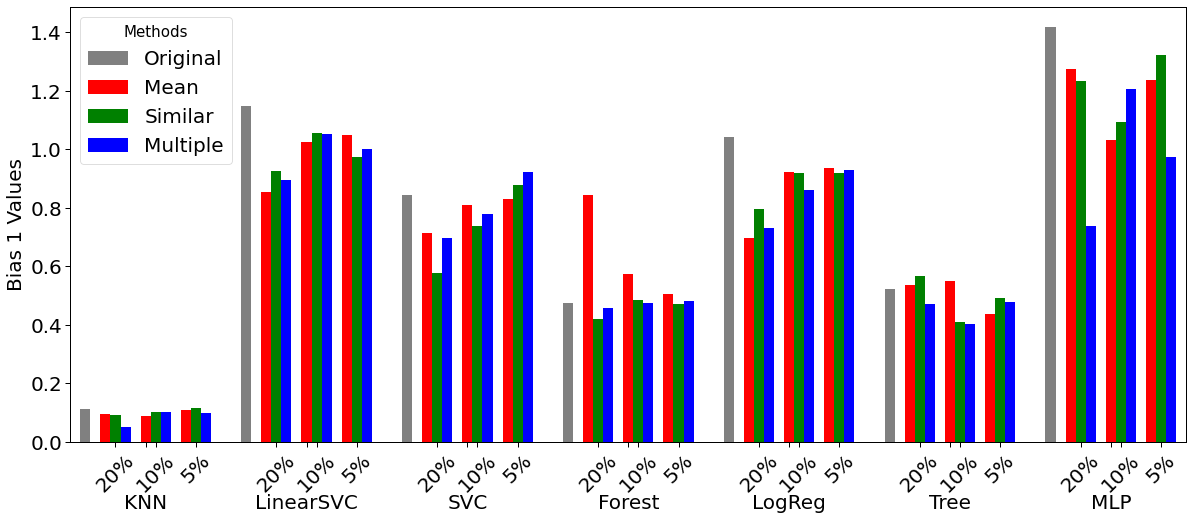

In [237]:
fig = plt.figure(figsize=(20, 8))
fig.patch.set_alpha(1.0)
ax = fig.add_subplot(111)
ax.tick_params(labelsize=20)
# plt.title("Compas Analysis: Bias 1", fontsize=20)
plot_basic_pos = np.arange(len(classifiers)) * 16
plot_additional_pos = [0, 2, 3, 4, 6, 7, 8, 10, 11, 12]
plot_xticks_pos = np.array([np.array([3.5, 6.5, 7.5, 11.5]) + m for m in plot_basic_pos]).ravel().tolist()
plot_xtick_labels = np.array([["20%", "\n\n{}".format(name), "10%", "5%"] for name in classifiers]).ravel().tolist()
plot_data = []
for clf_name in classifiers:
    dd = pd.read_csv(os.path.join("compas_analysis", clf_name, "bias1.csv"), index_col=0)
    avg = dd.loc["Average"].tolist()
    plot_data.append(avg)
plot_data = np.array(plot_data).T
plot_methods = ["Original", "Mean", "Similar", "Multiple"]
plot_barcolors = ["grey", "red", "green", "blue",
                  "red", "green", "blue",
                  "red", "green", "blue"]
for (i, method) in enumerate(methods):
    ax.bar(plot_basic_pos + plot_additional_pos[i] + 0.5, plot_data[i], 1, label=plot_methods[i] if i < 4 else None, color=plot_barcolors[i])
plt.xticks(plot_xticks_pos)
ax.set_xticklabels(plot_xtick_labels)
for label in ax.get_xmajorticklabels():
    if "%" in label.get_text():
        label.set_rotation(45)
        label.set_horizontalalignment("center")
plt.ylabel("Bias 1 Values", fontsize=20)
plt.xlim([-1, 16*len(classifiers) - 2])
plt.legend(title="Methods", loc="upper left", prop={"size": 20}, title_fontsize=15)
plt.savefig("bias1.png", transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

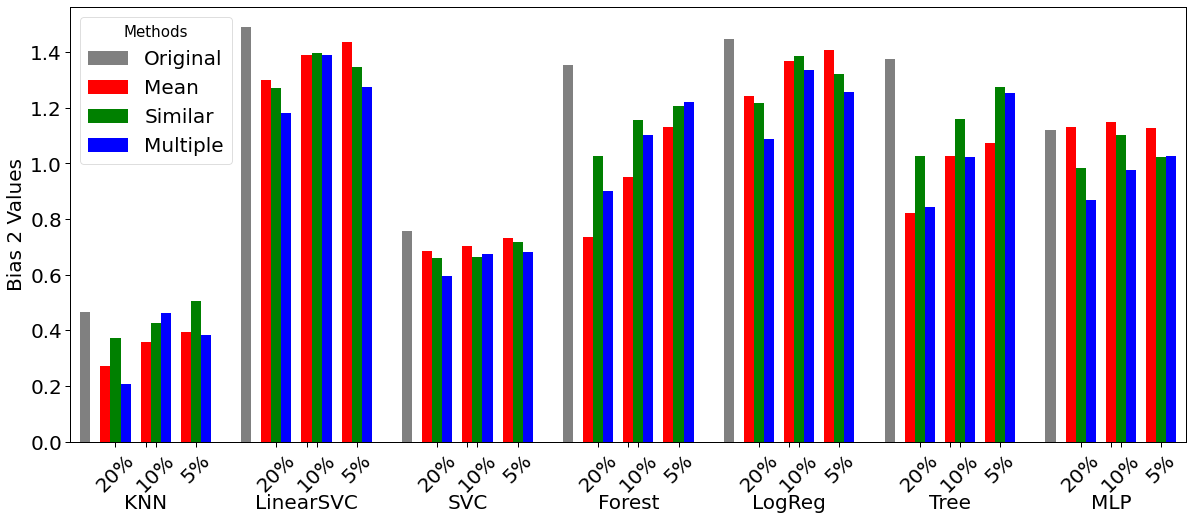

In [238]:
fig = plt.figure(figsize=(20, 8))
fig.patch.set_alpha(1.0)
ax = fig.add_subplot(111)
ax.tick_params(labelsize=20)
# plt.title("Compas Analysis: Bias 2", fontsize=20)
plot_basic_pos = np.arange(len(classifiers)) * 16
plot_additional_pos = [0, 2, 3, 4, 6, 7, 8, 10, 11, 12]
plot_xticks_pos = np.array([np.array([3.5, 6.5, 7.5, 11.5]) + m for m in plot_basic_pos]).ravel().tolist()
plot_xtick_labels = np.array([["20%", "\n\n{}".format(name), "10%", "5%"] for name in classifiers]).ravel().tolist()
plot_data = []
for clf_name in classifiers:
    dd = pd.read_csv(os.path.join("compas_analysis", clf_name, "bias2.csv"), index_col=0)
    avg = dd.loc["Average"].tolist()
    plot_data.append(avg)
plot_data = np.array(plot_data).T
plot_methods = ["Original", "Mean", "Similar", "Multiple"]
plot_barcolors = ["grey", "red", "green", "blue",
                  "red", "green", "blue",
                  "red", "green", "blue"]
for (i, method) in enumerate(methods):
    ax.bar(plot_basic_pos + plot_additional_pos[i] + 0.5, plot_data[i], 1, label=plot_methods[i] if i < 4 else None, color=plot_barcolors[i])
plt.xticks(plot_xticks_pos)
ax.set_xticklabels(plot_xtick_labels)
for label in ax.get_xmajorticklabels():
    if "%" in label.get_text():
        label.set_rotation(45)
        label.set_horizontalalignment("center")
plt.ylabel("Bias 2 Values", fontsize=20)
plt.xlim([-1, 16*len(classifiers) - 2])
plt.legend(title="Methods", loc="upper left", prop={"size": 20}, title_fontsize=15)
plt.savefig("bias2.png", transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

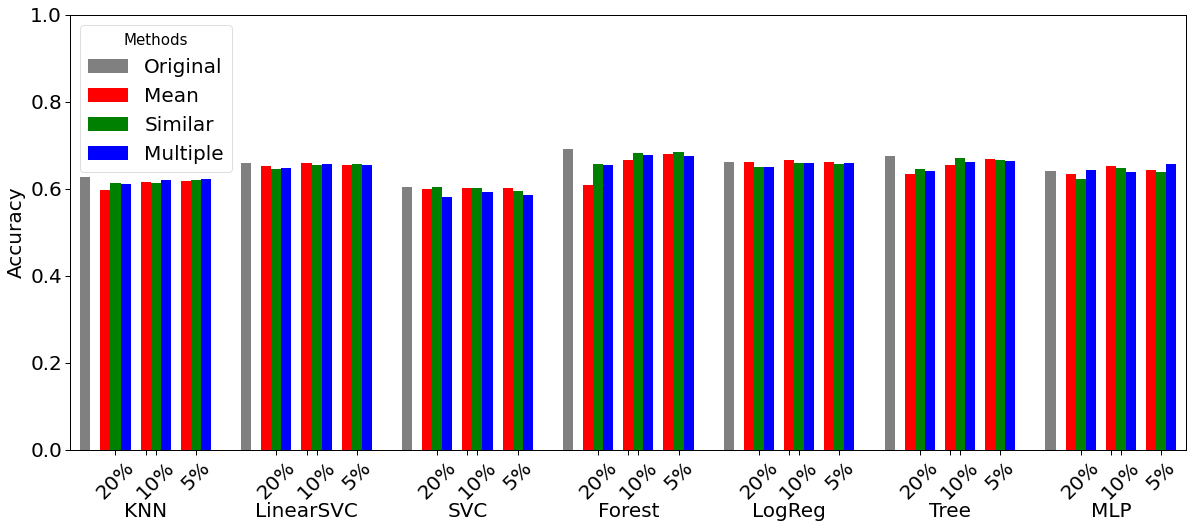

In [239]:
fig = plt.figure(figsize=(20, 8))
fig.patch.set_alpha(1.0)
ax = fig.add_subplot(111)
ax.tick_params(labelsize=20)
# plt.title("Compas Analysis: Accuracy", fontsize=20)
plot_basic_pos = np.arange(len(classifiers)) * 16
plot_additional_pos = [0, 2, 3, 4, 6, 7, 8, 10, 11, 12]
plot_xticks_pos = np.array([np.array([3.5, 6.5, 7.5, 11.5]) + m for m in plot_basic_pos]).ravel().tolist()
plot_xtick_labels = np.array([["20%", "\n\n{}".format(name), "10%", "5%"] for name in classifiers]).ravel().tolist()
plot_data = []
for clf_name in classifiers:
    dd = pd.read_csv(os.path.join("compas_analysis", clf_name, "accuracy.csv"), index_col=0)
    avg = dd.loc["Average"].tolist()
    plot_data.append(avg)
plot_data = np.array(plot_data).T
plot_methods = ["Original", "Mean", "Similar", "Multiple"]
plot_barcolors = ["grey", "red", "green", "blue",
                  "red", "green", "blue",
                  "red", "green", "blue"]
for (i, method) in enumerate(methods):
    ax.bar(plot_basic_pos + plot_additional_pos[i] + 0.5, plot_data[i], 1, label=plot_methods[i] if i < 4 else None, color=plot_barcolors[i])
plt.xticks(plot_xticks_pos)
ax.set_xticklabels(plot_xtick_labels)
for label in ax.get_xmajorticklabels():
    if "%" in label.get_text():
        label.set_rotation(45)
        label.set_horizontalalignment("center")
plt.ylabel("Accuracy", fontsize=20)
plt.xlim([-1, 16*len(classifiers) - 2])
plt.ylim([0.0, 1.0])
plt.legend(title="Methods", loc="upper left", prop={"size": 20}, title_fontsize=15)
plt.savefig("accuracy.png", transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

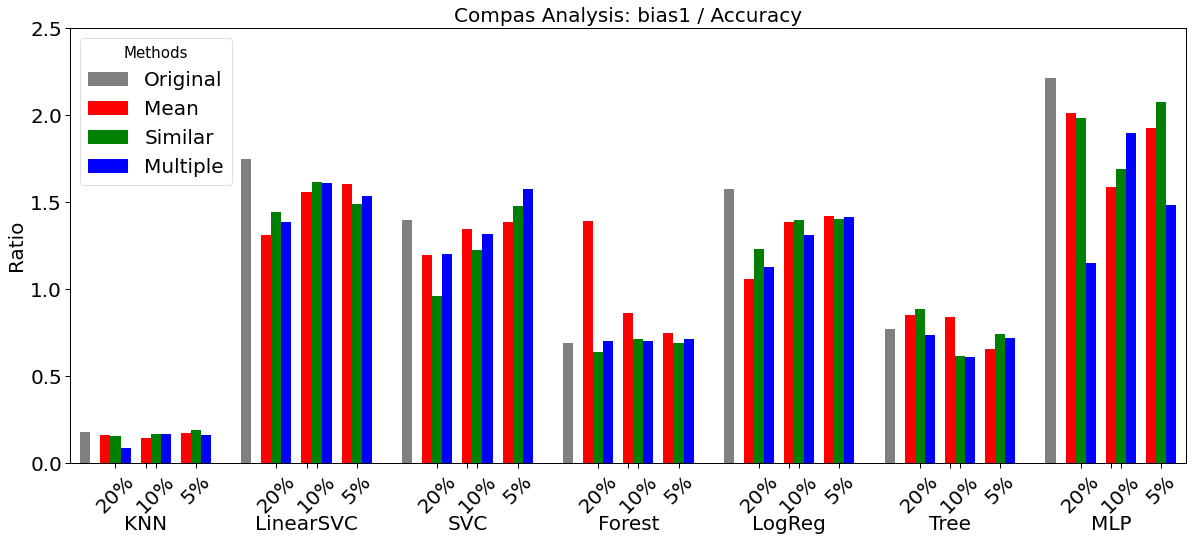

In [240]:
fig = plt.figure(figsize=(20, 8))
fig.patch.set_alpha(1.0)
ax = fig.add_subplot(111)
ax.tick_params(labelsize=20)
plt.title("Compas Analysis: bias1 / Accuracy", fontsize=20)
plot_basic_pos = np.arange(len(classifiers)) * 16
plot_additional_pos = [0, 2, 3, 4, 6, 7, 8, 10, 11, 12]
plot_xticks_pos = np.array([np.array([3.5, 6.5, 7.5, 11.5]) + m for m in plot_basic_pos]).ravel().tolist()
plot_xtick_labels = np.array([["20%", "\n\n{}".format(name), "10%", "5%"] for name in classifiers]).ravel().tolist()
plot_data = []
for clf_name in classifiers:
    dd1 = pd.read_csv(os.path.join("compas_analysis", clf_name, "accuracy.csv"), index_col=0)
    avg1 = np.array(dd1.loc["Average"].tolist())
    dd2 = pd.read_csv(os.path.join("compas_analysis", clf_name, "bias1.csv"), index_col=0)
    avg2 = np.array(dd2.loc["Average"].tolist())
    avg = avg2 / avg1
    plot_data.append(avg.tolist())
plot_data = np.array(plot_data).T
plot_methods = ["Original", "Mean", "Similar", "Multiple"]
plot_barcolors = ["grey", "red", "green", "blue",
                  "red", "green", "blue",
                  "red", "green", "blue"]
for (i, method) in enumerate(methods):
    ax.bar(plot_basic_pos + plot_additional_pos[i] + 0.5, plot_data[i], 1, label=plot_methods[i] if i < 4 else None, color=plot_barcolors[i])
plt.xticks(plot_xticks_pos)
ax.set_xticklabels(plot_xtick_labels)
for label in ax.get_xmajorticklabels():
    if "%" in label.get_text():
        label.set_rotation(45)
        label.set_horizontalalignment("center")
plt.ylabel("Ratio", fontsize=20)
plt.xlim([-1, 16*len(classifiers) - 2])
plt.ylim([0.0, 2.5])
plt.legend(title="Methods", loc="upper left", prop={"size": 20}, title_fontsize=15)
plt.savefig("ratio1.png", transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

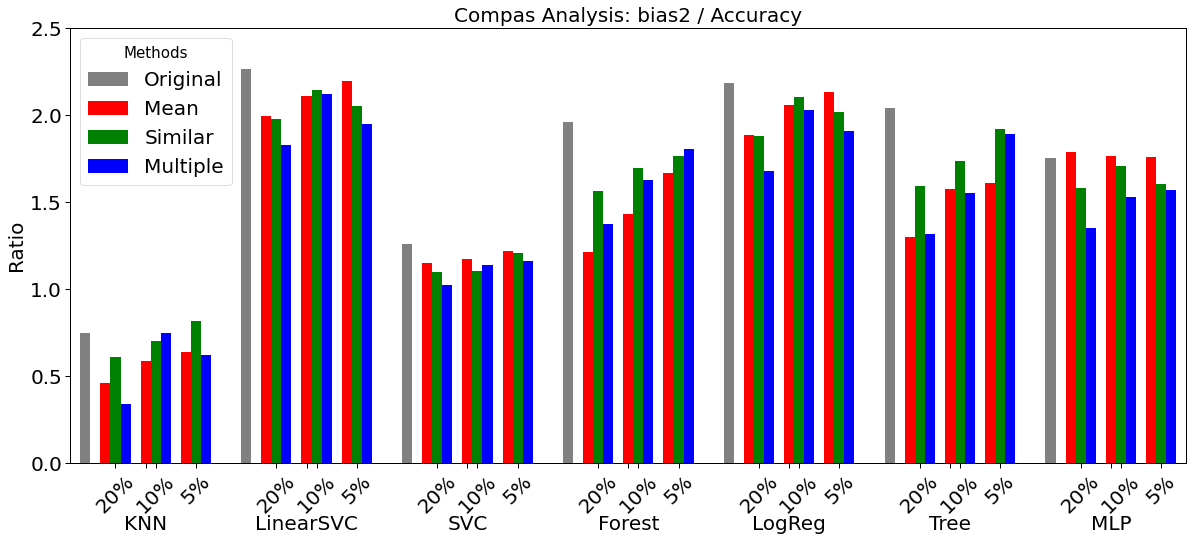

In [241]:
fig = plt.figure(figsize=(20, 8))
fig.patch.set_alpha(1.0)
ax = fig.add_subplot(111)
ax.tick_params(labelsize=20)
plt.title("Compas Analysis: bias2 / Accuracy", fontsize=20)
plot_basic_pos = np.arange(len(classifiers)) * 16
plot_additional_pos = [0, 2, 3, 4, 6, 7, 8, 10, 11, 12]
plot_xticks_pos = np.array([np.array([3.5, 6.5, 7.5, 11.5]) + m for m in plot_basic_pos]).ravel().tolist()
plot_xtick_labels = np.array([["20%", "\n\n{}".format(name), "10%", "5%"] for name in classifiers]).ravel().tolist()
plot_data = []
for clf_name in classifiers:
    dd1 = pd.read_csv(os.path.join("compas_analysis", clf_name, "accuracy.csv"), index_col=0)
    avg1 = np.array(dd1.loc["Average"].tolist())
    dd2 = pd.read_csv(os.path.join("compas_analysis", clf_name, "bias2.csv"), index_col=0)
    avg2 = np.array(dd2.loc["Average"].tolist())
    avg = avg2 / avg1
    plot_data.append(avg.tolist())
plot_data = np.array(plot_data).T
plot_methods = ["Original", "Mean", "Similar", "Multiple"]
plot_barcolors = ["grey", "red", "green", "blue",
                  "red", "green", "blue",
                  "red", "green", "blue"]
for (i, method) in enumerate(methods):
    ax.bar(plot_basic_pos + plot_additional_pos[i] + 0.5, plot_data[i], 1, label=plot_methods[i] if i < 4 else None, color=plot_barcolors[i])
plt.xticks(plot_xticks_pos)
ax.set_xticklabels(plot_xtick_labels)
for label in ax.get_xmajorticklabels():
    if "%" in label.get_text():
        label.set_rotation(45)
        label.set_horizontalalignment("center")
plt.ylabel("Ratio", fontsize=20)
plt.xlim([-1, 16*len(classifiers) - 2])
plt.ylim([0.0, 2.5])
plt.legend(title="Methods", loc="upper left", prop={"size": 20}, title_fontsize=15)
plt.savefig("ratio2.png", transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()